This project is meant for sing language detection using continuous motion capture and realtime camera access within google colab



In [1]:
!pip install tensorflow opencv-python mediapipe matplotlib

In [4]:
import cv2
import mediapipe as mp
import numpy as np
import time
import os
import matplotlib.pyplot as plt

# Importing a common Mediapipe solution for detection
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

2. creating keypoints using mp holistic

In [5]:
def mediapipe_detection(image, model):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # Make the image writable to pass by reference to MediaPipe.
  # This ensures the 'writable' flag exists and can be manipulated.
  image = image.copy()
  image.flags.writable = False
  results = model.process(image)
  image.flags.writable = True
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image, results

In [6]:
def draw_landmarks(image, results):
  mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) #drwaing face connection
  mp_drawing.draw_landmarks(image,results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # drawing the pose
  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # drwaing the left hand
  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # drawing the right hand

In [16]:
def draw_styled_landmarks(image, results):
  #Drawing face connections
  mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                            mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                            mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
  #Drawing pose connections
  mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))

  #Drawing left hand connections
  mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(121, 22,76), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(121, 44, 250),thickness=2, circle_radius=2))

  #Drawing Right hand connections
  mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                            mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2))

In [8]:
cap = cv2.VideoCapture(0)
#Setting mediapipe mode
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  while cap.isOpened():
    #read the feed
    ret, frame = cap.read()

    #make detection
    image, results = mediapipe_detection(frame, holistic)
    print(results)

    #draw landmarks
    draw_styled_landmarks(image, results)

    #show to screen
    cv2.imshow('OpenCV Feed', image)

    #break gracefully
    if cv2.waitkey(10) & 0xFF == ord('q'):
      break

    cap.release()
    cv2.destroyAllWindows()


In [6]:
frame_path = "/content/images/img_1.jpg"

# Check if the image file exists before proceeding
if os.path.exists(frame_path):
    # Read the image using opencv
    image = cv2.imread(frame_path)

    # Check if image was loaded successfully
    if image is not None:
        # Create a holistic model instance
        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            # Make detection and get results
            image, results = mediapipe_detection(image, holistic)
            # Now call draw_landmarks with the image and results
            draw_landmarks(image, results)
            # Display the image with landmarks
            cv2_imshow(image)
    else:
        print(f"Error: Could not load image from {frame_path}")
else:
    print(f"Error: Image file not found at {frame_path}")

AttributeError: 'numpy._core.multiarray.flagsobj' object has no attribute 'writable'

<IPython.core.display.Javascript object>

Captured: 
Saved to: images/captured_photo.jpg

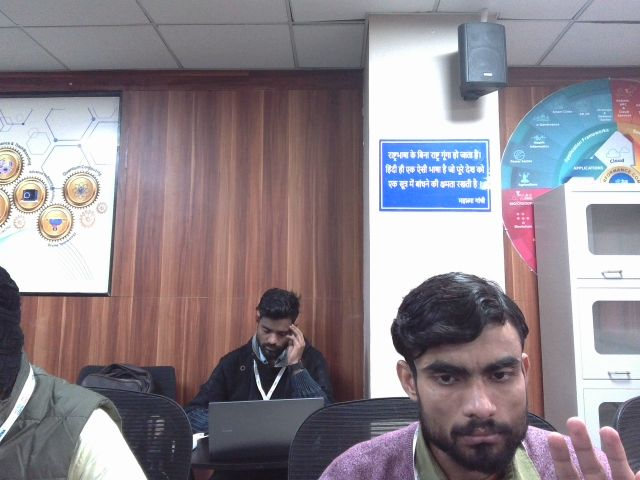

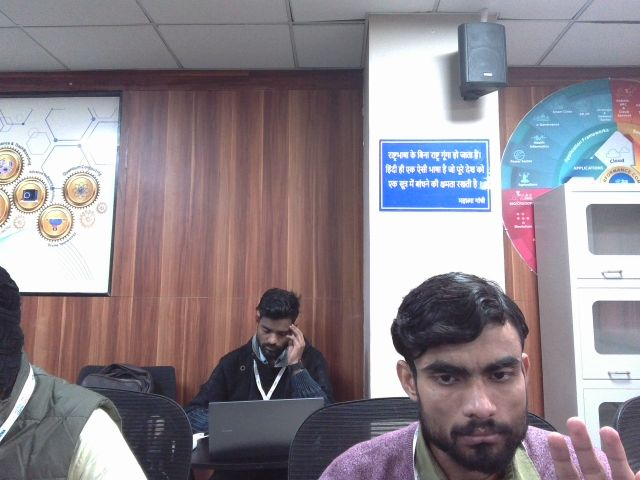

In [10]:
import os
import cv2
import numpy as np
from base64 import b64decode
from google.colab.patches import cv2_imshow

# Make sure the images folder exists
os.makedirs("images", exist_ok=True)

try:
    # Capture photo
    filename = take_photo('photo.jpg')
    print("Captured:", filename)

    # Decode base64 image from the returned data
    image_bytes = b64decode(filename.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)

    # Save to images folder
    save_path = "images/captured_photo.jpg"
    cv2.imwrite(save_path, img)
    print("Saved to:", save_path)

    # Display the saved image
    cv2_imshow(img)

except Exception as err:
    print("Error:", str(err))


In [46]:
import os
import cv2
import numpy as np
from base64 import b64decode
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js

# --- Webcam Capture Function ---
def capture_webcam_frames(num_frames=30, quality=0.8):
    js = Javascript('''
        async function captureWebcamFrames(numFrames, quality) {
          const div = document.createElement('div');
          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          const frames = [];
          const canvas = document.createElement('canvas');

          for (let i = 0; i < numFrames; i++) {
            await new Promise(resolve => setTimeout(resolve, 100)); // Capture frame every 100ms (10 FPS)
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            frames.push(canvas.toDataURL('image/jpeg', quality));
          }

          stream.getVideoTracks()[0].stop();
          div.remove();
          return frames;
        }
    ''')
    display(js)
    frames_data = eval_js('captureWebcamFrames({}, {})'.format(num_frames, quality))
    return frames_data

# --- Ensure images folder exists ---
os.makedirs("images", exist_ok=True)

# --- Auto-generate next file name (not used for sequential frames directly but kept for context) ---
def get_next_filename():
    existing = [f for f in os.listdir("images") if f.startswith("img_") and f.endswith(".jpg")]
    if not existing:
        return "images/img_1.jpg"

    # Extract numbers
    nums = [int(f.split("_")[1].split(".")[0]) for f in existing]
    next_num = max(nums) + 1
    return f"images/img_{next_num}.jpg"

# The main logic for single photo capture is commented out as we're switching to frame capture
# try:
#     data = take_photo()

#     # Decode the image
#     image_bytes = b64decode(data.split(',')[1])
#     jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
#     img = cv2.imdecode(jpg_as_np, flags=1)

#     # Get next filename and save
#     save_path = get_next_filename()
#     cv2.imwrite(save_path, img)

#     print("Image saved as:", save_path)

#     # Display the image
#     cv2_imshow(img)

# except Exception as err:
#     print("Error:", str(err))


In [49]:
import cv2
import mediapipe as mp
import numpy as np
import os
from base64 import b64decode
from IPython.display import display, Javascript
from google.colab.output import eval_js

# Ensure the capture_webcam_frames function is available (from cell gBUPGxd_2PAJ)
# It's good practice to re-define or ensure it's executed before this cell.

print("Starting keypoint data collection...")

# Set mediapipe model outside the loop to avoid re-initializing
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through actions
    for action in actions:
        # Ensure base directory for action exists
        os.makedirs(os.path.join(DATA_PATH, action), exist_ok=True)

        # Get existing directories for this action to determine starting sequence number
        existing_dirs = [d for d in os.path.join(DATA_PATH, action) if d.isdigit()]
        if existing_dirs:
            dir_start = np.max(np.array(existing_dirs).astype(int)) + 1
        else:
            dir_start = 1 # Start from 1 if no existing numbered directories

        # Loop through sequences aka videos
        for sequence in range(dir_start, dir_start + no_sequences):
            print(f"\nCollecting frames for action: {action}, Video Number: {sequence}")
            print("Please perform the sign in front of the webcam when prompted...")

            # Capture frames using the JavaScript webcam function
            captured_frames_data = capture_webcam_frames(num_frames=sequence_length, quality=0.8)
            print(f"Captured {len(captured_frames_data)} frames.")

            # Create directory for the current sequence
            seq_dir = os.path.join(DATA_PATH, action, str(sequence))
            os.makedirs(seq_dir, exist_ok=True)

            # Loop through video length aka sequence length
            for frame_num, frame_data_url in enumerate(captured_frames_data):
                # Decode base64 image
                image_bytes = b64decode(frame_data_url.split(',')[1])
                jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
                frame_bgr = cv2.imdecode(jpg_as_np, flags=1)

                # Make detections
                image_processed, results = mediapipe_detection(frame_bgr, holistic)

                # Draw landmarks (optional, but good for visualization if you want to display)
                # You can comment out the next two lines if you don't need real-time display during collection
                # draw_styled_landmarks(image_processed, results)
                # cv2_imshow(image_processed) # This will display each frame, which might be slow

                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(seq_dir, str(frame_num))
                np.save(npy_path, keypoints)

                print(f"  Saved frame {frame_num+1}/{sequence_length} keypoints to {npy_path}.npy")

print("Data collection complete!")


Starting keypoint data collection...

Please perform the sign in front of the webcam when prompted...


<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/1/0.npy
  Saved frame 2/30 keypoints to images/hello/1/1.npy
  Saved frame 3/30 keypoints to images/hello/1/2.npy
  Saved frame 4/30 keypoints to images/hello/1/3.npy
  Saved frame 5/30 keypoints to images/hello/1/4.npy


/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


  Saved frame 6/30 keypoints to images/hello/1/5.npy
  Saved frame 7/30 keypoints to images/hello/1/6.npy
  Saved frame 8/30 keypoints to images/hello/1/7.npy
  Saved frame 9/30 keypoints to images/hello/1/8.npy
  Saved frame 10/30 keypoints to images/hello/1/9.npy
  Saved frame 11/30 keypoints to images/hello/1/10.npy
  Saved frame 12/30 keypoints to images/hello/1/11.npy
  Saved frame 13/30 keypoints to images/hello/1/12.npy
  Saved frame 14/30 keypoints to images/hello/1/13.npy
  Saved frame 15/30 keypoints to images/hello/1/14.npy
  Saved frame 16/30 keypoints to images/hello/1/15.npy
  Saved frame 17/30 keypoints to images/hello/1/16.npy
  Saved frame 18/30 keypoints to images/hello/1/17.npy
  Saved frame 19/30 keypoints to images/hello/1/18.npy
  Saved frame 20/30 keypoints to images/hello/1/19.npy
  Saved frame 21/30 keypoints to images/hello/1/20.npy
  Saved frame 22/30 keypoints to images/hello/1/21.npy
  Saved frame 23/30 keypoints to images/hello/1/22.npy
  Saved frame 24/30

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/2/0.npy
  Saved frame 2/30 keypoints to images/hello/2/1.npy
  Saved frame 3/30 keypoints to images/hello/2/2.npy
  Saved frame 4/30 keypoints to images/hello/2/3.npy
  Saved frame 5/30 keypoints to images/hello/2/4.npy
  Saved frame 6/30 keypoints to images/hello/2/5.npy
  Saved frame 7/30 keypoints to images/hello/2/6.npy
  Saved frame 8/30 keypoints to images/hello/2/7.npy
  Saved frame 9/30 keypoints to images/hello/2/8.npy
  Saved frame 10/30 keypoints to images/hello/2/9.npy
  Saved frame 11/30 keypoints to images/hello/2/10.npy
  Saved frame 12/30 keypoints to images/hello/2/11.npy
  Saved frame 13/30 keypoints to images/hello/2/12.npy
  Saved frame 14/30 keypoints to images/hello/2/13.npy
  Saved frame 15/30 keypoints to images/hello/2/14.npy
  Saved frame 16/30 keypoints to images/hello/2/15.npy
  Saved frame 17/30 keypoints to images/hello/2/16.npy
  Saved frame 18/30 keypoints to images/hello/2/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/3/0.npy
  Saved frame 2/30 keypoints to images/hello/3/1.npy
  Saved frame 3/30 keypoints to images/hello/3/2.npy
  Saved frame 4/30 keypoints to images/hello/3/3.npy
  Saved frame 5/30 keypoints to images/hello/3/4.npy
  Saved frame 6/30 keypoints to images/hello/3/5.npy
  Saved frame 7/30 keypoints to images/hello/3/6.npy
  Saved frame 8/30 keypoints to images/hello/3/7.npy
  Saved frame 9/30 keypoints to images/hello/3/8.npy
  Saved frame 10/30 keypoints to images/hello/3/9.npy
  Saved frame 11/30 keypoints to images/hello/3/10.npy
  Saved frame 12/30 keypoints to images/hello/3/11.npy
  Saved frame 13/30 keypoints to images/hello/3/12.npy
  Saved frame 14/30 keypoints to images/hello/3/13.npy
  Saved frame 15/30 keypoints to images/hello/3/14.npy
  Saved frame 16/30 keypoints to images/hello/3/15.npy
  Saved frame 17/30 keypoints to images/hello/3/16.npy
  Saved frame 18/30 keypoints to images/hello/3/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/4/0.npy
  Saved frame 2/30 keypoints to images/hello/4/1.npy
  Saved frame 3/30 keypoints to images/hello/4/2.npy
  Saved frame 4/30 keypoints to images/hello/4/3.npy
  Saved frame 5/30 keypoints to images/hello/4/4.npy
  Saved frame 6/30 keypoints to images/hello/4/5.npy
  Saved frame 7/30 keypoints to images/hello/4/6.npy
  Saved frame 8/30 keypoints to images/hello/4/7.npy
  Saved frame 9/30 keypoints to images/hello/4/8.npy
  Saved frame 10/30 keypoints to images/hello/4/9.npy
  Saved frame 11/30 keypoints to images/hello/4/10.npy
  Saved frame 12/30 keypoints to images/hello/4/11.npy
  Saved frame 13/30 keypoints to images/hello/4/12.npy
  Saved frame 14/30 keypoints to images/hello/4/13.npy
  Saved frame 15/30 keypoints to images/hello/4/14.npy
  Saved frame 16/30 keypoints to images/hello/4/15.npy
  Saved frame 17/30 keypoints to images/hello/4/16.npy
  Saved frame 18/30 keypoints to images/hello/4/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/5/0.npy
  Saved frame 2/30 keypoints to images/hello/5/1.npy
  Saved frame 3/30 keypoints to images/hello/5/2.npy
  Saved frame 4/30 keypoints to images/hello/5/3.npy
  Saved frame 5/30 keypoints to images/hello/5/4.npy
  Saved frame 6/30 keypoints to images/hello/5/5.npy
  Saved frame 7/30 keypoints to images/hello/5/6.npy
  Saved frame 8/30 keypoints to images/hello/5/7.npy
  Saved frame 9/30 keypoints to images/hello/5/8.npy
  Saved frame 10/30 keypoints to images/hello/5/9.npy
  Saved frame 11/30 keypoints to images/hello/5/10.npy
  Saved frame 12/30 keypoints to images/hello/5/11.npy
  Saved frame 13/30 keypoints to images/hello/5/12.npy
  Saved frame 14/30 keypoints to images/hello/5/13.npy
  Saved frame 15/30 keypoints to images/hello/5/14.npy
  Saved frame 16/30 keypoints to images/hello/5/15.npy
  Saved frame 17/30 keypoints to images/hello/5/16.npy
  Saved frame 18/30 keypoints to images/hello/5/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/6/0.npy
  Saved frame 2/30 keypoints to images/hello/6/1.npy
  Saved frame 3/30 keypoints to images/hello/6/2.npy
  Saved frame 4/30 keypoints to images/hello/6/3.npy
  Saved frame 5/30 keypoints to images/hello/6/4.npy
  Saved frame 6/30 keypoints to images/hello/6/5.npy
  Saved frame 7/30 keypoints to images/hello/6/6.npy
  Saved frame 8/30 keypoints to images/hello/6/7.npy
  Saved frame 9/30 keypoints to images/hello/6/8.npy
  Saved frame 10/30 keypoints to images/hello/6/9.npy
  Saved frame 11/30 keypoints to images/hello/6/10.npy
  Saved frame 12/30 keypoints to images/hello/6/11.npy
  Saved frame 13/30 keypoints to images/hello/6/12.npy
  Saved frame 14/30 keypoints to images/hello/6/13.npy
  Saved frame 15/30 keypoints to images/hello/6/14.npy
  Saved frame 16/30 keypoints to images/hello/6/15.npy
  Saved frame 17/30 keypoints to images/hello/6/16.npy
  Saved frame 18/30 keypoints to images/hello/6/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/7/0.npy
  Saved frame 2/30 keypoints to images/hello/7/1.npy
  Saved frame 3/30 keypoints to images/hello/7/2.npy
  Saved frame 4/30 keypoints to images/hello/7/3.npy
  Saved frame 5/30 keypoints to images/hello/7/4.npy
  Saved frame 6/30 keypoints to images/hello/7/5.npy
  Saved frame 7/30 keypoints to images/hello/7/6.npy
  Saved frame 8/30 keypoints to images/hello/7/7.npy
  Saved frame 9/30 keypoints to images/hello/7/8.npy
  Saved frame 10/30 keypoints to images/hello/7/9.npy
  Saved frame 11/30 keypoints to images/hello/7/10.npy
  Saved frame 12/30 keypoints to images/hello/7/11.npy
  Saved frame 13/30 keypoints to images/hello/7/12.npy
  Saved frame 14/30 keypoints to images/hello/7/13.npy
  Saved frame 15/30 keypoints to images/hello/7/14.npy
  Saved frame 16/30 keypoints to images/hello/7/15.npy
  Saved frame 17/30 keypoints to images/hello/7/16.npy
  Saved frame 18/30 keypoints to images/hello/7/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/8/0.npy
  Saved frame 2/30 keypoints to images/hello/8/1.npy
  Saved frame 3/30 keypoints to images/hello/8/2.npy
  Saved frame 4/30 keypoints to images/hello/8/3.npy
  Saved frame 5/30 keypoints to images/hello/8/4.npy
  Saved frame 6/30 keypoints to images/hello/8/5.npy
  Saved frame 7/30 keypoints to images/hello/8/6.npy
  Saved frame 8/30 keypoints to images/hello/8/7.npy
  Saved frame 9/30 keypoints to images/hello/8/8.npy
  Saved frame 10/30 keypoints to images/hello/8/9.npy
  Saved frame 11/30 keypoints to images/hello/8/10.npy
  Saved frame 12/30 keypoints to images/hello/8/11.npy
  Saved frame 13/30 keypoints to images/hello/8/12.npy
  Saved frame 14/30 keypoints to images/hello/8/13.npy
  Saved frame 15/30 keypoints to images/hello/8/14.npy
  Saved frame 16/30 keypoints to images/hello/8/15.npy
  Saved frame 17/30 keypoints to images/hello/8/16.npy
  Saved frame 18/30 keypoints to images/hello/8/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/9/0.npy
  Saved frame 2/30 keypoints to images/hello/9/1.npy
  Saved frame 3/30 keypoints to images/hello/9/2.npy
  Saved frame 4/30 keypoints to images/hello/9/3.npy
  Saved frame 5/30 keypoints to images/hello/9/4.npy
  Saved frame 6/30 keypoints to images/hello/9/5.npy
  Saved frame 7/30 keypoints to images/hello/9/6.npy
  Saved frame 8/30 keypoints to images/hello/9/7.npy
  Saved frame 9/30 keypoints to images/hello/9/8.npy
  Saved frame 10/30 keypoints to images/hello/9/9.npy
  Saved frame 11/30 keypoints to images/hello/9/10.npy
  Saved frame 12/30 keypoints to images/hello/9/11.npy
  Saved frame 13/30 keypoints to images/hello/9/12.npy
  Saved frame 14/30 keypoints to images/hello/9/13.npy
  Saved frame 15/30 keypoints to images/hello/9/14.npy
  Saved frame 16/30 keypoints to images/hello/9/15.npy
  Saved frame 17/30 keypoints to images/hello/9/16.npy
  Saved frame 18/30 keypoints to images/hello/9/17.npy
  Saved f

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/10/0.npy
  Saved frame 2/30 keypoints to images/hello/10/1.npy
  Saved frame 3/30 keypoints to images/hello/10/2.npy
  Saved frame 4/30 keypoints to images/hello/10/3.npy
  Saved frame 5/30 keypoints to images/hello/10/4.npy
  Saved frame 6/30 keypoints to images/hello/10/5.npy
  Saved frame 7/30 keypoints to images/hello/10/6.npy
  Saved frame 8/30 keypoints to images/hello/10/7.npy
  Saved frame 9/30 keypoints to images/hello/10/8.npy
  Saved frame 10/30 keypoints to images/hello/10/9.npy
  Saved frame 11/30 keypoints to images/hello/10/10.npy
  Saved frame 12/30 keypoints to images/hello/10/11.npy
  Saved frame 13/30 keypoints to images/hello/10/12.npy
  Saved frame 14/30 keypoints to images/hello/10/13.npy
  Saved frame 15/30 keypoints to images/hello/10/14.npy
  Saved frame 16/30 keypoints to images/hello/10/15.npy
  Saved frame 17/30 keypoints to images/hello/10/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/11/0.npy
  Saved frame 2/30 keypoints to images/hello/11/1.npy
  Saved frame 3/30 keypoints to images/hello/11/2.npy
  Saved frame 4/30 keypoints to images/hello/11/3.npy
  Saved frame 5/30 keypoints to images/hello/11/4.npy
  Saved frame 6/30 keypoints to images/hello/11/5.npy
  Saved frame 7/30 keypoints to images/hello/11/6.npy
  Saved frame 8/30 keypoints to images/hello/11/7.npy
  Saved frame 9/30 keypoints to images/hello/11/8.npy
  Saved frame 10/30 keypoints to images/hello/11/9.npy
  Saved frame 11/30 keypoints to images/hello/11/10.npy
  Saved frame 12/30 keypoints to images/hello/11/11.npy
  Saved frame 13/30 keypoints to images/hello/11/12.npy
  Saved frame 14/30 keypoints to images/hello/11/13.npy
  Saved frame 15/30 keypoints to images/hello/11/14.npy
  Saved frame 16/30 keypoints to images/hello/11/15.npy
  Saved frame 17/30 keypoints to images/hello/11/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/12/0.npy
  Saved frame 2/30 keypoints to images/hello/12/1.npy
  Saved frame 3/30 keypoints to images/hello/12/2.npy
  Saved frame 4/30 keypoints to images/hello/12/3.npy
  Saved frame 5/30 keypoints to images/hello/12/4.npy
  Saved frame 6/30 keypoints to images/hello/12/5.npy
  Saved frame 7/30 keypoints to images/hello/12/6.npy
  Saved frame 8/30 keypoints to images/hello/12/7.npy
  Saved frame 9/30 keypoints to images/hello/12/8.npy
  Saved frame 10/30 keypoints to images/hello/12/9.npy
  Saved frame 11/30 keypoints to images/hello/12/10.npy
  Saved frame 12/30 keypoints to images/hello/12/11.npy
  Saved frame 13/30 keypoints to images/hello/12/12.npy
  Saved frame 14/30 keypoints to images/hello/12/13.npy
  Saved frame 15/30 keypoints to images/hello/12/14.npy
  Saved frame 16/30 keypoints to images/hello/12/15.npy
  Saved frame 17/30 keypoints to images/hello/12/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/13/0.npy
  Saved frame 2/30 keypoints to images/hello/13/1.npy
  Saved frame 3/30 keypoints to images/hello/13/2.npy
  Saved frame 4/30 keypoints to images/hello/13/3.npy
  Saved frame 5/30 keypoints to images/hello/13/4.npy
  Saved frame 6/30 keypoints to images/hello/13/5.npy
  Saved frame 7/30 keypoints to images/hello/13/6.npy
  Saved frame 8/30 keypoints to images/hello/13/7.npy
  Saved frame 9/30 keypoints to images/hello/13/8.npy
  Saved frame 10/30 keypoints to images/hello/13/9.npy
  Saved frame 11/30 keypoints to images/hello/13/10.npy
  Saved frame 12/30 keypoints to images/hello/13/11.npy
  Saved frame 13/30 keypoints to images/hello/13/12.npy
  Saved frame 14/30 keypoints to images/hello/13/13.npy
  Saved frame 15/30 keypoints to images/hello/13/14.npy
  Saved frame 16/30 keypoints to images/hello/13/15.npy
  Saved frame 17/30 keypoints to images/hello/13/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/14/0.npy
  Saved frame 2/30 keypoints to images/hello/14/1.npy
  Saved frame 3/30 keypoints to images/hello/14/2.npy
  Saved frame 4/30 keypoints to images/hello/14/3.npy
  Saved frame 5/30 keypoints to images/hello/14/4.npy
  Saved frame 6/30 keypoints to images/hello/14/5.npy
  Saved frame 7/30 keypoints to images/hello/14/6.npy
  Saved frame 8/30 keypoints to images/hello/14/7.npy
  Saved frame 9/30 keypoints to images/hello/14/8.npy
  Saved frame 10/30 keypoints to images/hello/14/9.npy
  Saved frame 11/30 keypoints to images/hello/14/10.npy
  Saved frame 12/30 keypoints to images/hello/14/11.npy
  Saved frame 13/30 keypoints to images/hello/14/12.npy
  Saved frame 14/30 keypoints to images/hello/14/13.npy
  Saved frame 15/30 keypoints to images/hello/14/14.npy
  Saved frame 16/30 keypoints to images/hello/14/15.npy
  Saved frame 17/30 keypoints to images/hello/14/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/15/0.npy
  Saved frame 2/30 keypoints to images/hello/15/1.npy
  Saved frame 3/30 keypoints to images/hello/15/2.npy
  Saved frame 4/30 keypoints to images/hello/15/3.npy
  Saved frame 5/30 keypoints to images/hello/15/4.npy
  Saved frame 6/30 keypoints to images/hello/15/5.npy
  Saved frame 7/30 keypoints to images/hello/15/6.npy
  Saved frame 8/30 keypoints to images/hello/15/7.npy
  Saved frame 9/30 keypoints to images/hello/15/8.npy
  Saved frame 10/30 keypoints to images/hello/15/9.npy
  Saved frame 11/30 keypoints to images/hello/15/10.npy
  Saved frame 12/30 keypoints to images/hello/15/11.npy
  Saved frame 13/30 keypoints to images/hello/15/12.npy
  Saved frame 14/30 keypoints to images/hello/15/13.npy
  Saved frame 15/30 keypoints to images/hello/15/14.npy
  Saved frame 16/30 keypoints to images/hello/15/15.npy
  Saved frame 17/30 keypoints to images/hello/15/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/16/0.npy
  Saved frame 2/30 keypoints to images/hello/16/1.npy
  Saved frame 3/30 keypoints to images/hello/16/2.npy
  Saved frame 4/30 keypoints to images/hello/16/3.npy
  Saved frame 5/30 keypoints to images/hello/16/4.npy
  Saved frame 6/30 keypoints to images/hello/16/5.npy
  Saved frame 7/30 keypoints to images/hello/16/6.npy
  Saved frame 8/30 keypoints to images/hello/16/7.npy
  Saved frame 9/30 keypoints to images/hello/16/8.npy
  Saved frame 10/30 keypoints to images/hello/16/9.npy
  Saved frame 11/30 keypoints to images/hello/16/10.npy
  Saved frame 12/30 keypoints to images/hello/16/11.npy
  Saved frame 13/30 keypoints to images/hello/16/12.npy
  Saved frame 14/30 keypoints to images/hello/16/13.npy
  Saved frame 15/30 keypoints to images/hello/16/14.npy
  Saved frame 16/30 keypoints to images/hello/16/15.npy
  Saved frame 17/30 keypoints to images/hello/16/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/17/0.npy
  Saved frame 2/30 keypoints to images/hello/17/1.npy
  Saved frame 3/30 keypoints to images/hello/17/2.npy
  Saved frame 4/30 keypoints to images/hello/17/3.npy
  Saved frame 5/30 keypoints to images/hello/17/4.npy
  Saved frame 6/30 keypoints to images/hello/17/5.npy
  Saved frame 7/30 keypoints to images/hello/17/6.npy
  Saved frame 8/30 keypoints to images/hello/17/7.npy
  Saved frame 9/30 keypoints to images/hello/17/8.npy
  Saved frame 10/30 keypoints to images/hello/17/9.npy
  Saved frame 11/30 keypoints to images/hello/17/10.npy
  Saved frame 12/30 keypoints to images/hello/17/11.npy
  Saved frame 13/30 keypoints to images/hello/17/12.npy
  Saved frame 14/30 keypoints to images/hello/17/13.npy
  Saved frame 15/30 keypoints to images/hello/17/14.npy
  Saved frame 16/30 keypoints to images/hello/17/15.npy
  Saved frame 17/30 keypoints to images/hello/17/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/18/0.npy
  Saved frame 2/30 keypoints to images/hello/18/1.npy
  Saved frame 3/30 keypoints to images/hello/18/2.npy
  Saved frame 4/30 keypoints to images/hello/18/3.npy
  Saved frame 5/30 keypoints to images/hello/18/4.npy
  Saved frame 6/30 keypoints to images/hello/18/5.npy
  Saved frame 7/30 keypoints to images/hello/18/6.npy
  Saved frame 8/30 keypoints to images/hello/18/7.npy
  Saved frame 9/30 keypoints to images/hello/18/8.npy
  Saved frame 10/30 keypoints to images/hello/18/9.npy
  Saved frame 11/30 keypoints to images/hello/18/10.npy
  Saved frame 12/30 keypoints to images/hello/18/11.npy
  Saved frame 13/30 keypoints to images/hello/18/12.npy
  Saved frame 14/30 keypoints to images/hello/18/13.npy
  Saved frame 15/30 keypoints to images/hello/18/14.npy
  Saved frame 16/30 keypoints to images/hello/18/15.npy
  Saved frame 17/30 keypoints to images/hello/18/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/19/0.npy
  Saved frame 2/30 keypoints to images/hello/19/1.npy
  Saved frame 3/30 keypoints to images/hello/19/2.npy
  Saved frame 4/30 keypoints to images/hello/19/3.npy
  Saved frame 5/30 keypoints to images/hello/19/4.npy
  Saved frame 6/30 keypoints to images/hello/19/5.npy
  Saved frame 7/30 keypoints to images/hello/19/6.npy
  Saved frame 8/30 keypoints to images/hello/19/7.npy
  Saved frame 9/30 keypoints to images/hello/19/8.npy
  Saved frame 10/30 keypoints to images/hello/19/9.npy
  Saved frame 11/30 keypoints to images/hello/19/10.npy
  Saved frame 12/30 keypoints to images/hello/19/11.npy
  Saved frame 13/30 keypoints to images/hello/19/12.npy
  Saved frame 14/30 keypoints to images/hello/19/13.npy
  Saved frame 15/30 keypoints to images/hello/19/14.npy
  Saved frame 16/30 keypoints to images/hello/19/15.npy
  Saved frame 17/30 keypoints to images/hello/19/16.npy
  Saved frame 18/30 keypoints to images/hello/1

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/20/0.npy
  Saved frame 2/30 keypoints to images/hello/20/1.npy
  Saved frame 3/30 keypoints to images/hello/20/2.npy
  Saved frame 4/30 keypoints to images/hello/20/3.npy
  Saved frame 5/30 keypoints to images/hello/20/4.npy
  Saved frame 6/30 keypoints to images/hello/20/5.npy
  Saved frame 7/30 keypoints to images/hello/20/6.npy
  Saved frame 8/30 keypoints to images/hello/20/7.npy
  Saved frame 9/30 keypoints to images/hello/20/8.npy
  Saved frame 10/30 keypoints to images/hello/20/9.npy
  Saved frame 11/30 keypoints to images/hello/20/10.npy
  Saved frame 12/30 keypoints to images/hello/20/11.npy
  Saved frame 13/30 keypoints to images/hello/20/12.npy
  Saved frame 14/30 keypoints to images/hello/20/13.npy
  Saved frame 15/30 keypoints to images/hello/20/14.npy
  Saved frame 16/30 keypoints to images/hello/20/15.npy
  Saved frame 17/30 keypoints to images/hello/20/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/21/0.npy
  Saved frame 2/30 keypoints to images/hello/21/1.npy
  Saved frame 3/30 keypoints to images/hello/21/2.npy
  Saved frame 4/30 keypoints to images/hello/21/3.npy
  Saved frame 5/30 keypoints to images/hello/21/4.npy
  Saved frame 6/30 keypoints to images/hello/21/5.npy
  Saved frame 7/30 keypoints to images/hello/21/6.npy
  Saved frame 8/30 keypoints to images/hello/21/7.npy
  Saved frame 9/30 keypoints to images/hello/21/8.npy
  Saved frame 10/30 keypoints to images/hello/21/9.npy
  Saved frame 11/30 keypoints to images/hello/21/10.npy
  Saved frame 12/30 keypoints to images/hello/21/11.npy
  Saved frame 13/30 keypoints to images/hello/21/12.npy
  Saved frame 14/30 keypoints to images/hello/21/13.npy
  Saved frame 15/30 keypoints to images/hello/21/14.npy
  Saved frame 16/30 keypoints to images/hello/21/15.npy
  Saved frame 17/30 keypoints to images/hello/21/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/22/0.npy
  Saved frame 2/30 keypoints to images/hello/22/1.npy
  Saved frame 3/30 keypoints to images/hello/22/2.npy
  Saved frame 4/30 keypoints to images/hello/22/3.npy
  Saved frame 5/30 keypoints to images/hello/22/4.npy
  Saved frame 6/30 keypoints to images/hello/22/5.npy
  Saved frame 7/30 keypoints to images/hello/22/6.npy
  Saved frame 8/30 keypoints to images/hello/22/7.npy
  Saved frame 9/30 keypoints to images/hello/22/8.npy
  Saved frame 10/30 keypoints to images/hello/22/9.npy
  Saved frame 11/30 keypoints to images/hello/22/10.npy
  Saved frame 12/30 keypoints to images/hello/22/11.npy
  Saved frame 13/30 keypoints to images/hello/22/12.npy
  Saved frame 14/30 keypoints to images/hello/22/13.npy
  Saved frame 15/30 keypoints to images/hello/22/14.npy
  Saved frame 16/30 keypoints to images/hello/22/15.npy
  Saved frame 17/30 keypoints to images/hello/22/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/23/0.npy
  Saved frame 2/30 keypoints to images/hello/23/1.npy
  Saved frame 3/30 keypoints to images/hello/23/2.npy
  Saved frame 4/30 keypoints to images/hello/23/3.npy
  Saved frame 5/30 keypoints to images/hello/23/4.npy
  Saved frame 6/30 keypoints to images/hello/23/5.npy
  Saved frame 7/30 keypoints to images/hello/23/6.npy
  Saved frame 8/30 keypoints to images/hello/23/7.npy
  Saved frame 9/30 keypoints to images/hello/23/8.npy
  Saved frame 10/30 keypoints to images/hello/23/9.npy
  Saved frame 11/30 keypoints to images/hello/23/10.npy
  Saved frame 12/30 keypoints to images/hello/23/11.npy
  Saved frame 13/30 keypoints to images/hello/23/12.npy
  Saved frame 14/30 keypoints to images/hello/23/13.npy
  Saved frame 15/30 keypoints to images/hello/23/14.npy
  Saved frame 16/30 keypoints to images/hello/23/15.npy
  Saved frame 17/30 keypoints to images/hello/23/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/24/0.npy
  Saved frame 2/30 keypoints to images/hello/24/1.npy
  Saved frame 3/30 keypoints to images/hello/24/2.npy
  Saved frame 4/30 keypoints to images/hello/24/3.npy
  Saved frame 5/30 keypoints to images/hello/24/4.npy
  Saved frame 6/30 keypoints to images/hello/24/5.npy
  Saved frame 7/30 keypoints to images/hello/24/6.npy
  Saved frame 8/30 keypoints to images/hello/24/7.npy
  Saved frame 9/30 keypoints to images/hello/24/8.npy
  Saved frame 10/30 keypoints to images/hello/24/9.npy
  Saved frame 11/30 keypoints to images/hello/24/10.npy
  Saved frame 12/30 keypoints to images/hello/24/11.npy
  Saved frame 13/30 keypoints to images/hello/24/12.npy
  Saved frame 14/30 keypoints to images/hello/24/13.npy
  Saved frame 15/30 keypoints to images/hello/24/14.npy
  Saved frame 16/30 keypoints to images/hello/24/15.npy
  Saved frame 17/30 keypoints to images/hello/24/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/25/0.npy
  Saved frame 2/30 keypoints to images/hello/25/1.npy
  Saved frame 3/30 keypoints to images/hello/25/2.npy
  Saved frame 4/30 keypoints to images/hello/25/3.npy
  Saved frame 5/30 keypoints to images/hello/25/4.npy
  Saved frame 6/30 keypoints to images/hello/25/5.npy
  Saved frame 7/30 keypoints to images/hello/25/6.npy
  Saved frame 8/30 keypoints to images/hello/25/7.npy
  Saved frame 9/30 keypoints to images/hello/25/8.npy
  Saved frame 10/30 keypoints to images/hello/25/9.npy
  Saved frame 11/30 keypoints to images/hello/25/10.npy
  Saved frame 12/30 keypoints to images/hello/25/11.npy
  Saved frame 13/30 keypoints to images/hello/25/12.npy
  Saved frame 14/30 keypoints to images/hello/25/13.npy
  Saved frame 15/30 keypoints to images/hello/25/14.npy
  Saved frame 16/30 keypoints to images/hello/25/15.npy
  Saved frame 17/30 keypoints to images/hello/25/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/26/0.npy
  Saved frame 2/30 keypoints to images/hello/26/1.npy
  Saved frame 3/30 keypoints to images/hello/26/2.npy
  Saved frame 4/30 keypoints to images/hello/26/3.npy
  Saved frame 5/30 keypoints to images/hello/26/4.npy
  Saved frame 6/30 keypoints to images/hello/26/5.npy
  Saved frame 7/30 keypoints to images/hello/26/6.npy
  Saved frame 8/30 keypoints to images/hello/26/7.npy
  Saved frame 9/30 keypoints to images/hello/26/8.npy
  Saved frame 10/30 keypoints to images/hello/26/9.npy
  Saved frame 11/30 keypoints to images/hello/26/10.npy
  Saved frame 12/30 keypoints to images/hello/26/11.npy
  Saved frame 13/30 keypoints to images/hello/26/12.npy
  Saved frame 14/30 keypoints to images/hello/26/13.npy
  Saved frame 15/30 keypoints to images/hello/26/14.npy
  Saved frame 16/30 keypoints to images/hello/26/15.npy
  Saved frame 17/30 keypoints to images/hello/26/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/27/0.npy
  Saved frame 2/30 keypoints to images/hello/27/1.npy
  Saved frame 3/30 keypoints to images/hello/27/2.npy
  Saved frame 4/30 keypoints to images/hello/27/3.npy
  Saved frame 5/30 keypoints to images/hello/27/4.npy
  Saved frame 6/30 keypoints to images/hello/27/5.npy
  Saved frame 7/30 keypoints to images/hello/27/6.npy
  Saved frame 8/30 keypoints to images/hello/27/7.npy
  Saved frame 9/30 keypoints to images/hello/27/8.npy
  Saved frame 10/30 keypoints to images/hello/27/9.npy
  Saved frame 11/30 keypoints to images/hello/27/10.npy
  Saved frame 12/30 keypoints to images/hello/27/11.npy
  Saved frame 13/30 keypoints to images/hello/27/12.npy
  Saved frame 14/30 keypoints to images/hello/27/13.npy
  Saved frame 15/30 keypoints to images/hello/27/14.npy
  Saved frame 16/30 keypoints to images/hello/27/15.npy
  Saved frame 17/30 keypoints to images/hello/27/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/28/0.npy
  Saved frame 2/30 keypoints to images/hello/28/1.npy
  Saved frame 3/30 keypoints to images/hello/28/2.npy
  Saved frame 4/30 keypoints to images/hello/28/3.npy
  Saved frame 5/30 keypoints to images/hello/28/4.npy
  Saved frame 6/30 keypoints to images/hello/28/5.npy
  Saved frame 7/30 keypoints to images/hello/28/6.npy
  Saved frame 8/30 keypoints to images/hello/28/7.npy
  Saved frame 9/30 keypoints to images/hello/28/8.npy
  Saved frame 10/30 keypoints to images/hello/28/9.npy
  Saved frame 11/30 keypoints to images/hello/28/10.npy
  Saved frame 12/30 keypoints to images/hello/28/11.npy
  Saved frame 13/30 keypoints to images/hello/28/12.npy
  Saved frame 14/30 keypoints to images/hello/28/13.npy
  Saved frame 15/30 keypoints to images/hello/28/14.npy
  Saved frame 16/30 keypoints to images/hello/28/15.npy
  Saved frame 17/30 keypoints to images/hello/28/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/29/0.npy
  Saved frame 2/30 keypoints to images/hello/29/1.npy
  Saved frame 3/30 keypoints to images/hello/29/2.npy
  Saved frame 4/30 keypoints to images/hello/29/3.npy
  Saved frame 5/30 keypoints to images/hello/29/4.npy
  Saved frame 6/30 keypoints to images/hello/29/5.npy
  Saved frame 7/30 keypoints to images/hello/29/6.npy
  Saved frame 8/30 keypoints to images/hello/29/7.npy
  Saved frame 9/30 keypoints to images/hello/29/8.npy
  Saved frame 10/30 keypoints to images/hello/29/9.npy
  Saved frame 11/30 keypoints to images/hello/29/10.npy
  Saved frame 12/30 keypoints to images/hello/29/11.npy
  Saved frame 13/30 keypoints to images/hello/29/12.npy
  Saved frame 14/30 keypoints to images/hello/29/13.npy
  Saved frame 15/30 keypoints to images/hello/29/14.npy
  Saved frame 16/30 keypoints to images/hello/29/15.npy
  Saved frame 17/30 keypoints to images/hello/29/16.npy
  Saved frame 18/30 keypoints to images/hello/2

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/hello/30/0.npy
  Saved frame 2/30 keypoints to images/hello/30/1.npy
  Saved frame 3/30 keypoints to images/hello/30/2.npy
  Saved frame 4/30 keypoints to images/hello/30/3.npy
  Saved frame 5/30 keypoints to images/hello/30/4.npy
  Saved frame 6/30 keypoints to images/hello/30/5.npy
  Saved frame 7/30 keypoints to images/hello/30/6.npy
  Saved frame 8/30 keypoints to images/hello/30/7.npy
  Saved frame 9/30 keypoints to images/hello/30/8.npy
  Saved frame 10/30 keypoints to images/hello/30/9.npy
  Saved frame 11/30 keypoints to images/hello/30/10.npy
  Saved frame 12/30 keypoints to images/hello/30/11.npy
  Saved frame 13/30 keypoints to images/hello/30/12.npy
  Saved frame 14/30 keypoints to images/hello/30/13.npy
  Saved frame 15/30 keypoints to images/hello/30/14.npy
  Saved frame 16/30 keypoints to images/hello/30/15.npy
  Saved frame 17/30 keypoints to images/hello/30/16.npy
  Saved frame 18/30 keypoints to images/hello/3

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/1/0.npy
  Saved frame 2/30 keypoints to images/thanks/1/1.npy
  Saved frame 3/30 keypoints to images/thanks/1/2.npy
  Saved frame 4/30 keypoints to images/thanks/1/3.npy
  Saved frame 5/30 keypoints to images/thanks/1/4.npy
  Saved frame 6/30 keypoints to images/thanks/1/5.npy
  Saved frame 7/30 keypoints to images/thanks/1/6.npy
  Saved frame 8/30 keypoints to images/thanks/1/7.npy
  Saved frame 9/30 keypoints to images/thanks/1/8.npy
  Saved frame 10/30 keypoints to images/thanks/1/9.npy
  Saved frame 11/30 keypoints to images/thanks/1/10.npy
  Saved frame 12/30 keypoints to images/thanks/1/11.npy
  Saved frame 13/30 keypoints to images/thanks/1/12.npy
  Saved frame 14/30 keypoints to images/thanks/1/13.npy
  Saved frame 15/30 keypoints to images/thanks/1/14.npy
  Saved frame 16/30 keypoints to images/thanks/1/15.npy
  Saved frame 17/30 keypoints to images/thanks/1/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/2/0.npy
  Saved frame 2/30 keypoints to images/thanks/2/1.npy
  Saved frame 3/30 keypoints to images/thanks/2/2.npy
  Saved frame 4/30 keypoints to images/thanks/2/3.npy
  Saved frame 5/30 keypoints to images/thanks/2/4.npy
  Saved frame 6/30 keypoints to images/thanks/2/5.npy
  Saved frame 7/30 keypoints to images/thanks/2/6.npy
  Saved frame 8/30 keypoints to images/thanks/2/7.npy
  Saved frame 9/30 keypoints to images/thanks/2/8.npy
  Saved frame 10/30 keypoints to images/thanks/2/9.npy
  Saved frame 11/30 keypoints to images/thanks/2/10.npy
  Saved frame 12/30 keypoints to images/thanks/2/11.npy
  Saved frame 13/30 keypoints to images/thanks/2/12.npy
  Saved frame 14/30 keypoints to images/thanks/2/13.npy
  Saved frame 15/30 keypoints to images/thanks/2/14.npy
  Saved frame 16/30 keypoints to images/thanks/2/15.npy
  Saved frame 17/30 keypoints to images/thanks/2/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/3/0.npy
  Saved frame 2/30 keypoints to images/thanks/3/1.npy
  Saved frame 3/30 keypoints to images/thanks/3/2.npy
  Saved frame 4/30 keypoints to images/thanks/3/3.npy
  Saved frame 5/30 keypoints to images/thanks/3/4.npy
  Saved frame 6/30 keypoints to images/thanks/3/5.npy
  Saved frame 7/30 keypoints to images/thanks/3/6.npy
  Saved frame 8/30 keypoints to images/thanks/3/7.npy
  Saved frame 9/30 keypoints to images/thanks/3/8.npy
  Saved frame 10/30 keypoints to images/thanks/3/9.npy
  Saved frame 11/30 keypoints to images/thanks/3/10.npy
  Saved frame 12/30 keypoints to images/thanks/3/11.npy
  Saved frame 13/30 keypoints to images/thanks/3/12.npy
  Saved frame 14/30 keypoints to images/thanks/3/13.npy
  Saved frame 15/30 keypoints to images/thanks/3/14.npy
  Saved frame 16/30 keypoints to images/thanks/3/15.npy
  Saved frame 17/30 keypoints to images/thanks/3/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/4/0.npy
  Saved frame 2/30 keypoints to images/thanks/4/1.npy
  Saved frame 3/30 keypoints to images/thanks/4/2.npy
  Saved frame 4/30 keypoints to images/thanks/4/3.npy
  Saved frame 5/30 keypoints to images/thanks/4/4.npy
  Saved frame 6/30 keypoints to images/thanks/4/5.npy
  Saved frame 7/30 keypoints to images/thanks/4/6.npy
  Saved frame 8/30 keypoints to images/thanks/4/7.npy
  Saved frame 9/30 keypoints to images/thanks/4/8.npy
  Saved frame 10/30 keypoints to images/thanks/4/9.npy
  Saved frame 11/30 keypoints to images/thanks/4/10.npy
  Saved frame 12/30 keypoints to images/thanks/4/11.npy
  Saved frame 13/30 keypoints to images/thanks/4/12.npy
  Saved frame 14/30 keypoints to images/thanks/4/13.npy
  Saved frame 15/30 keypoints to images/thanks/4/14.npy
  Saved frame 16/30 keypoints to images/thanks/4/15.npy
  Saved frame 17/30 keypoints to images/thanks/4/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/5/0.npy
  Saved frame 2/30 keypoints to images/thanks/5/1.npy
  Saved frame 3/30 keypoints to images/thanks/5/2.npy
  Saved frame 4/30 keypoints to images/thanks/5/3.npy
  Saved frame 5/30 keypoints to images/thanks/5/4.npy
  Saved frame 6/30 keypoints to images/thanks/5/5.npy
  Saved frame 7/30 keypoints to images/thanks/5/6.npy
  Saved frame 8/30 keypoints to images/thanks/5/7.npy
  Saved frame 9/30 keypoints to images/thanks/5/8.npy
  Saved frame 10/30 keypoints to images/thanks/5/9.npy
  Saved frame 11/30 keypoints to images/thanks/5/10.npy
  Saved frame 12/30 keypoints to images/thanks/5/11.npy
  Saved frame 13/30 keypoints to images/thanks/5/12.npy
  Saved frame 14/30 keypoints to images/thanks/5/13.npy
  Saved frame 15/30 keypoints to images/thanks/5/14.npy
  Saved frame 16/30 keypoints to images/thanks/5/15.npy
  Saved frame 17/30 keypoints to images/thanks/5/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/6/0.npy
  Saved frame 2/30 keypoints to images/thanks/6/1.npy
  Saved frame 3/30 keypoints to images/thanks/6/2.npy
  Saved frame 4/30 keypoints to images/thanks/6/3.npy
  Saved frame 5/30 keypoints to images/thanks/6/4.npy
  Saved frame 6/30 keypoints to images/thanks/6/5.npy
  Saved frame 7/30 keypoints to images/thanks/6/6.npy
  Saved frame 8/30 keypoints to images/thanks/6/7.npy
  Saved frame 9/30 keypoints to images/thanks/6/8.npy
  Saved frame 10/30 keypoints to images/thanks/6/9.npy
  Saved frame 11/30 keypoints to images/thanks/6/10.npy
  Saved frame 12/30 keypoints to images/thanks/6/11.npy
  Saved frame 13/30 keypoints to images/thanks/6/12.npy
  Saved frame 14/30 keypoints to images/thanks/6/13.npy
  Saved frame 15/30 keypoints to images/thanks/6/14.npy
  Saved frame 16/30 keypoints to images/thanks/6/15.npy
  Saved frame 17/30 keypoints to images/thanks/6/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/7/0.npy
  Saved frame 2/30 keypoints to images/thanks/7/1.npy
  Saved frame 3/30 keypoints to images/thanks/7/2.npy
  Saved frame 4/30 keypoints to images/thanks/7/3.npy
  Saved frame 5/30 keypoints to images/thanks/7/4.npy
  Saved frame 6/30 keypoints to images/thanks/7/5.npy
  Saved frame 7/30 keypoints to images/thanks/7/6.npy
  Saved frame 8/30 keypoints to images/thanks/7/7.npy
  Saved frame 9/30 keypoints to images/thanks/7/8.npy
  Saved frame 10/30 keypoints to images/thanks/7/9.npy
  Saved frame 11/30 keypoints to images/thanks/7/10.npy
  Saved frame 12/30 keypoints to images/thanks/7/11.npy
  Saved frame 13/30 keypoints to images/thanks/7/12.npy
  Saved frame 14/30 keypoints to images/thanks/7/13.npy
  Saved frame 15/30 keypoints to images/thanks/7/14.npy
  Saved frame 16/30 keypoints to images/thanks/7/15.npy
  Saved frame 17/30 keypoints to images/thanks/7/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/8/0.npy
  Saved frame 2/30 keypoints to images/thanks/8/1.npy
  Saved frame 3/30 keypoints to images/thanks/8/2.npy
  Saved frame 4/30 keypoints to images/thanks/8/3.npy
  Saved frame 5/30 keypoints to images/thanks/8/4.npy
  Saved frame 6/30 keypoints to images/thanks/8/5.npy
  Saved frame 7/30 keypoints to images/thanks/8/6.npy
  Saved frame 8/30 keypoints to images/thanks/8/7.npy
  Saved frame 9/30 keypoints to images/thanks/8/8.npy
  Saved frame 10/30 keypoints to images/thanks/8/9.npy
  Saved frame 11/30 keypoints to images/thanks/8/10.npy
  Saved frame 12/30 keypoints to images/thanks/8/11.npy
  Saved frame 13/30 keypoints to images/thanks/8/12.npy
  Saved frame 14/30 keypoints to images/thanks/8/13.npy
  Saved frame 15/30 keypoints to images/thanks/8/14.npy
  Saved frame 16/30 keypoints to images/thanks/8/15.npy
  Saved frame 17/30 keypoints to images/thanks/8/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/9/0.npy
  Saved frame 2/30 keypoints to images/thanks/9/1.npy
  Saved frame 3/30 keypoints to images/thanks/9/2.npy
  Saved frame 4/30 keypoints to images/thanks/9/3.npy
  Saved frame 5/30 keypoints to images/thanks/9/4.npy
  Saved frame 6/30 keypoints to images/thanks/9/5.npy
  Saved frame 7/30 keypoints to images/thanks/9/6.npy
  Saved frame 8/30 keypoints to images/thanks/9/7.npy
  Saved frame 9/30 keypoints to images/thanks/9/8.npy
  Saved frame 10/30 keypoints to images/thanks/9/9.npy
  Saved frame 11/30 keypoints to images/thanks/9/10.npy
  Saved frame 12/30 keypoints to images/thanks/9/11.npy
  Saved frame 13/30 keypoints to images/thanks/9/12.npy
  Saved frame 14/30 keypoints to images/thanks/9/13.npy
  Saved frame 15/30 keypoints to images/thanks/9/14.npy
  Saved frame 16/30 keypoints to images/thanks/9/15.npy
  Saved frame 17/30 keypoints to images/thanks/9/16.npy
  Saved frame 18/30 keypoints to images/thanks/

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/10/0.npy
  Saved frame 2/30 keypoints to images/thanks/10/1.npy
  Saved frame 3/30 keypoints to images/thanks/10/2.npy
  Saved frame 4/30 keypoints to images/thanks/10/3.npy
  Saved frame 5/30 keypoints to images/thanks/10/4.npy
  Saved frame 6/30 keypoints to images/thanks/10/5.npy
  Saved frame 7/30 keypoints to images/thanks/10/6.npy
  Saved frame 8/30 keypoints to images/thanks/10/7.npy
  Saved frame 9/30 keypoints to images/thanks/10/8.npy
  Saved frame 10/30 keypoints to images/thanks/10/9.npy
  Saved frame 11/30 keypoints to images/thanks/10/10.npy
  Saved frame 12/30 keypoints to images/thanks/10/11.npy
  Saved frame 13/30 keypoints to images/thanks/10/12.npy
  Saved frame 14/30 keypoints to images/thanks/10/13.npy
  Saved frame 15/30 keypoints to images/thanks/10/14.npy
  Saved frame 16/30 keypoints to images/thanks/10/15.npy
  Saved frame 17/30 keypoints to images/thanks/10/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/11/0.npy
  Saved frame 2/30 keypoints to images/thanks/11/1.npy
  Saved frame 3/30 keypoints to images/thanks/11/2.npy
  Saved frame 4/30 keypoints to images/thanks/11/3.npy
  Saved frame 5/30 keypoints to images/thanks/11/4.npy
  Saved frame 6/30 keypoints to images/thanks/11/5.npy
  Saved frame 7/30 keypoints to images/thanks/11/6.npy
  Saved frame 8/30 keypoints to images/thanks/11/7.npy
  Saved frame 9/30 keypoints to images/thanks/11/8.npy
  Saved frame 10/30 keypoints to images/thanks/11/9.npy
  Saved frame 11/30 keypoints to images/thanks/11/10.npy
  Saved frame 12/30 keypoints to images/thanks/11/11.npy
  Saved frame 13/30 keypoints to images/thanks/11/12.npy
  Saved frame 14/30 keypoints to images/thanks/11/13.npy
  Saved frame 15/30 keypoints to images/thanks/11/14.npy
  Saved frame 16/30 keypoints to images/thanks/11/15.npy
  Saved frame 17/30 keypoints to images/thanks/11/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/12/0.npy
  Saved frame 2/30 keypoints to images/thanks/12/1.npy
  Saved frame 3/30 keypoints to images/thanks/12/2.npy
  Saved frame 4/30 keypoints to images/thanks/12/3.npy
  Saved frame 5/30 keypoints to images/thanks/12/4.npy
  Saved frame 6/30 keypoints to images/thanks/12/5.npy
  Saved frame 7/30 keypoints to images/thanks/12/6.npy
  Saved frame 8/30 keypoints to images/thanks/12/7.npy
  Saved frame 9/30 keypoints to images/thanks/12/8.npy
  Saved frame 10/30 keypoints to images/thanks/12/9.npy
  Saved frame 11/30 keypoints to images/thanks/12/10.npy
  Saved frame 12/30 keypoints to images/thanks/12/11.npy
  Saved frame 13/30 keypoints to images/thanks/12/12.npy
  Saved frame 14/30 keypoints to images/thanks/12/13.npy
  Saved frame 15/30 keypoints to images/thanks/12/14.npy
  Saved frame 16/30 keypoints to images/thanks/12/15.npy
  Saved frame 17/30 keypoints to images/thanks/12/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/13/0.npy
  Saved frame 2/30 keypoints to images/thanks/13/1.npy
  Saved frame 3/30 keypoints to images/thanks/13/2.npy
  Saved frame 4/30 keypoints to images/thanks/13/3.npy
  Saved frame 5/30 keypoints to images/thanks/13/4.npy
  Saved frame 6/30 keypoints to images/thanks/13/5.npy
  Saved frame 7/30 keypoints to images/thanks/13/6.npy
  Saved frame 8/30 keypoints to images/thanks/13/7.npy
  Saved frame 9/30 keypoints to images/thanks/13/8.npy
  Saved frame 10/30 keypoints to images/thanks/13/9.npy
  Saved frame 11/30 keypoints to images/thanks/13/10.npy
  Saved frame 12/30 keypoints to images/thanks/13/11.npy
  Saved frame 13/30 keypoints to images/thanks/13/12.npy
  Saved frame 14/30 keypoints to images/thanks/13/13.npy
  Saved frame 15/30 keypoints to images/thanks/13/14.npy
  Saved frame 16/30 keypoints to images/thanks/13/15.npy
  Saved frame 17/30 keypoints to images/thanks/13/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/14/0.npy
  Saved frame 2/30 keypoints to images/thanks/14/1.npy
  Saved frame 3/30 keypoints to images/thanks/14/2.npy
  Saved frame 4/30 keypoints to images/thanks/14/3.npy
  Saved frame 5/30 keypoints to images/thanks/14/4.npy
  Saved frame 6/30 keypoints to images/thanks/14/5.npy
  Saved frame 7/30 keypoints to images/thanks/14/6.npy
  Saved frame 8/30 keypoints to images/thanks/14/7.npy
  Saved frame 9/30 keypoints to images/thanks/14/8.npy
  Saved frame 10/30 keypoints to images/thanks/14/9.npy
  Saved frame 11/30 keypoints to images/thanks/14/10.npy
  Saved frame 12/30 keypoints to images/thanks/14/11.npy
  Saved frame 13/30 keypoints to images/thanks/14/12.npy
  Saved frame 14/30 keypoints to images/thanks/14/13.npy
  Saved frame 15/30 keypoints to images/thanks/14/14.npy
  Saved frame 16/30 keypoints to images/thanks/14/15.npy
  Saved frame 17/30 keypoints to images/thanks/14/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/15/0.npy
  Saved frame 2/30 keypoints to images/thanks/15/1.npy
  Saved frame 3/30 keypoints to images/thanks/15/2.npy
  Saved frame 4/30 keypoints to images/thanks/15/3.npy
  Saved frame 5/30 keypoints to images/thanks/15/4.npy
  Saved frame 6/30 keypoints to images/thanks/15/5.npy
  Saved frame 7/30 keypoints to images/thanks/15/6.npy
  Saved frame 8/30 keypoints to images/thanks/15/7.npy
  Saved frame 9/30 keypoints to images/thanks/15/8.npy
  Saved frame 10/30 keypoints to images/thanks/15/9.npy
  Saved frame 11/30 keypoints to images/thanks/15/10.npy
  Saved frame 12/30 keypoints to images/thanks/15/11.npy
  Saved frame 13/30 keypoints to images/thanks/15/12.npy
  Saved frame 14/30 keypoints to images/thanks/15/13.npy
  Saved frame 15/30 keypoints to images/thanks/15/14.npy
  Saved frame 16/30 keypoints to images/thanks/15/15.npy
  Saved frame 17/30 keypoints to images/thanks/15/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/16/0.npy
  Saved frame 2/30 keypoints to images/thanks/16/1.npy
  Saved frame 3/30 keypoints to images/thanks/16/2.npy
  Saved frame 4/30 keypoints to images/thanks/16/3.npy
  Saved frame 5/30 keypoints to images/thanks/16/4.npy
  Saved frame 6/30 keypoints to images/thanks/16/5.npy
  Saved frame 7/30 keypoints to images/thanks/16/6.npy
  Saved frame 8/30 keypoints to images/thanks/16/7.npy
  Saved frame 9/30 keypoints to images/thanks/16/8.npy
  Saved frame 10/30 keypoints to images/thanks/16/9.npy
  Saved frame 11/30 keypoints to images/thanks/16/10.npy
  Saved frame 12/30 keypoints to images/thanks/16/11.npy
  Saved frame 13/30 keypoints to images/thanks/16/12.npy
  Saved frame 14/30 keypoints to images/thanks/16/13.npy
  Saved frame 15/30 keypoints to images/thanks/16/14.npy
  Saved frame 16/30 keypoints to images/thanks/16/15.npy
  Saved frame 17/30 keypoints to images/thanks/16/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/17/0.npy
  Saved frame 2/30 keypoints to images/thanks/17/1.npy
  Saved frame 3/30 keypoints to images/thanks/17/2.npy
  Saved frame 4/30 keypoints to images/thanks/17/3.npy
  Saved frame 5/30 keypoints to images/thanks/17/4.npy
  Saved frame 6/30 keypoints to images/thanks/17/5.npy
  Saved frame 7/30 keypoints to images/thanks/17/6.npy
  Saved frame 8/30 keypoints to images/thanks/17/7.npy
  Saved frame 9/30 keypoints to images/thanks/17/8.npy
  Saved frame 10/30 keypoints to images/thanks/17/9.npy
  Saved frame 11/30 keypoints to images/thanks/17/10.npy
  Saved frame 12/30 keypoints to images/thanks/17/11.npy
  Saved frame 13/30 keypoints to images/thanks/17/12.npy
  Saved frame 14/30 keypoints to images/thanks/17/13.npy
  Saved frame 15/30 keypoints to images/thanks/17/14.npy
  Saved frame 16/30 keypoints to images/thanks/17/15.npy
  Saved frame 17/30 keypoints to images/thanks/17/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/18/0.npy
  Saved frame 2/30 keypoints to images/thanks/18/1.npy
  Saved frame 3/30 keypoints to images/thanks/18/2.npy
  Saved frame 4/30 keypoints to images/thanks/18/3.npy
  Saved frame 5/30 keypoints to images/thanks/18/4.npy
  Saved frame 6/30 keypoints to images/thanks/18/5.npy
  Saved frame 7/30 keypoints to images/thanks/18/6.npy
  Saved frame 8/30 keypoints to images/thanks/18/7.npy
  Saved frame 9/30 keypoints to images/thanks/18/8.npy
  Saved frame 10/30 keypoints to images/thanks/18/9.npy
  Saved frame 11/30 keypoints to images/thanks/18/10.npy
  Saved frame 12/30 keypoints to images/thanks/18/11.npy
  Saved frame 13/30 keypoints to images/thanks/18/12.npy
  Saved frame 14/30 keypoints to images/thanks/18/13.npy
  Saved frame 15/30 keypoints to images/thanks/18/14.npy
  Saved frame 16/30 keypoints to images/thanks/18/15.npy
  Saved frame 17/30 keypoints to images/thanks/18/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/19/0.npy
  Saved frame 2/30 keypoints to images/thanks/19/1.npy
  Saved frame 3/30 keypoints to images/thanks/19/2.npy
  Saved frame 4/30 keypoints to images/thanks/19/3.npy
  Saved frame 5/30 keypoints to images/thanks/19/4.npy
  Saved frame 6/30 keypoints to images/thanks/19/5.npy
  Saved frame 7/30 keypoints to images/thanks/19/6.npy
  Saved frame 8/30 keypoints to images/thanks/19/7.npy
  Saved frame 9/30 keypoints to images/thanks/19/8.npy
  Saved frame 10/30 keypoints to images/thanks/19/9.npy
  Saved frame 11/30 keypoints to images/thanks/19/10.npy
  Saved frame 12/30 keypoints to images/thanks/19/11.npy
  Saved frame 13/30 keypoints to images/thanks/19/12.npy
  Saved frame 14/30 keypoints to images/thanks/19/13.npy
  Saved frame 15/30 keypoints to images/thanks/19/14.npy
  Saved frame 16/30 keypoints to images/thanks/19/15.npy
  Saved frame 17/30 keypoints to images/thanks/19/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/20/0.npy
  Saved frame 2/30 keypoints to images/thanks/20/1.npy
  Saved frame 3/30 keypoints to images/thanks/20/2.npy
  Saved frame 4/30 keypoints to images/thanks/20/3.npy
  Saved frame 5/30 keypoints to images/thanks/20/4.npy
  Saved frame 6/30 keypoints to images/thanks/20/5.npy
  Saved frame 7/30 keypoints to images/thanks/20/6.npy
  Saved frame 8/30 keypoints to images/thanks/20/7.npy
  Saved frame 9/30 keypoints to images/thanks/20/8.npy
  Saved frame 10/30 keypoints to images/thanks/20/9.npy
  Saved frame 11/30 keypoints to images/thanks/20/10.npy
  Saved frame 12/30 keypoints to images/thanks/20/11.npy
  Saved frame 13/30 keypoints to images/thanks/20/12.npy
  Saved frame 14/30 keypoints to images/thanks/20/13.npy
  Saved frame 15/30 keypoints to images/thanks/20/14.npy
  Saved frame 16/30 keypoints to images/thanks/20/15.npy
  Saved frame 17/30 keypoints to images/thanks/20/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/21/0.npy
  Saved frame 2/30 keypoints to images/thanks/21/1.npy
  Saved frame 3/30 keypoints to images/thanks/21/2.npy
  Saved frame 4/30 keypoints to images/thanks/21/3.npy
  Saved frame 5/30 keypoints to images/thanks/21/4.npy
  Saved frame 6/30 keypoints to images/thanks/21/5.npy
  Saved frame 7/30 keypoints to images/thanks/21/6.npy
  Saved frame 8/30 keypoints to images/thanks/21/7.npy
  Saved frame 9/30 keypoints to images/thanks/21/8.npy
  Saved frame 10/30 keypoints to images/thanks/21/9.npy
  Saved frame 11/30 keypoints to images/thanks/21/10.npy
  Saved frame 12/30 keypoints to images/thanks/21/11.npy
  Saved frame 13/30 keypoints to images/thanks/21/12.npy
  Saved frame 14/30 keypoints to images/thanks/21/13.npy
  Saved frame 15/30 keypoints to images/thanks/21/14.npy
  Saved frame 16/30 keypoints to images/thanks/21/15.npy
  Saved frame 17/30 keypoints to images/thanks/21/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/22/0.npy
  Saved frame 2/30 keypoints to images/thanks/22/1.npy
  Saved frame 3/30 keypoints to images/thanks/22/2.npy
  Saved frame 4/30 keypoints to images/thanks/22/3.npy
  Saved frame 5/30 keypoints to images/thanks/22/4.npy
  Saved frame 6/30 keypoints to images/thanks/22/5.npy
  Saved frame 7/30 keypoints to images/thanks/22/6.npy
  Saved frame 8/30 keypoints to images/thanks/22/7.npy
  Saved frame 9/30 keypoints to images/thanks/22/8.npy
  Saved frame 10/30 keypoints to images/thanks/22/9.npy
  Saved frame 11/30 keypoints to images/thanks/22/10.npy
  Saved frame 12/30 keypoints to images/thanks/22/11.npy
  Saved frame 13/30 keypoints to images/thanks/22/12.npy
  Saved frame 14/30 keypoints to images/thanks/22/13.npy
  Saved frame 15/30 keypoints to images/thanks/22/14.npy
  Saved frame 16/30 keypoints to images/thanks/22/15.npy
  Saved frame 17/30 keypoints to images/thanks/22/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/23/0.npy
  Saved frame 2/30 keypoints to images/thanks/23/1.npy
  Saved frame 3/30 keypoints to images/thanks/23/2.npy
  Saved frame 4/30 keypoints to images/thanks/23/3.npy
  Saved frame 5/30 keypoints to images/thanks/23/4.npy
  Saved frame 6/30 keypoints to images/thanks/23/5.npy
  Saved frame 7/30 keypoints to images/thanks/23/6.npy
  Saved frame 8/30 keypoints to images/thanks/23/7.npy
  Saved frame 9/30 keypoints to images/thanks/23/8.npy
  Saved frame 10/30 keypoints to images/thanks/23/9.npy
  Saved frame 11/30 keypoints to images/thanks/23/10.npy
  Saved frame 12/30 keypoints to images/thanks/23/11.npy
  Saved frame 13/30 keypoints to images/thanks/23/12.npy
  Saved frame 14/30 keypoints to images/thanks/23/13.npy
  Saved frame 15/30 keypoints to images/thanks/23/14.npy
  Saved frame 16/30 keypoints to images/thanks/23/15.npy
  Saved frame 17/30 keypoints to images/thanks/23/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/24/0.npy
  Saved frame 2/30 keypoints to images/thanks/24/1.npy
  Saved frame 3/30 keypoints to images/thanks/24/2.npy
  Saved frame 4/30 keypoints to images/thanks/24/3.npy
  Saved frame 5/30 keypoints to images/thanks/24/4.npy
  Saved frame 6/30 keypoints to images/thanks/24/5.npy
  Saved frame 7/30 keypoints to images/thanks/24/6.npy
  Saved frame 8/30 keypoints to images/thanks/24/7.npy
  Saved frame 9/30 keypoints to images/thanks/24/8.npy
  Saved frame 10/30 keypoints to images/thanks/24/9.npy
  Saved frame 11/30 keypoints to images/thanks/24/10.npy
  Saved frame 12/30 keypoints to images/thanks/24/11.npy
  Saved frame 13/30 keypoints to images/thanks/24/12.npy
  Saved frame 14/30 keypoints to images/thanks/24/13.npy
  Saved frame 15/30 keypoints to images/thanks/24/14.npy
  Saved frame 16/30 keypoints to images/thanks/24/15.npy
  Saved frame 17/30 keypoints to images/thanks/24/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/25/0.npy
  Saved frame 2/30 keypoints to images/thanks/25/1.npy
  Saved frame 3/30 keypoints to images/thanks/25/2.npy
  Saved frame 4/30 keypoints to images/thanks/25/3.npy
  Saved frame 5/30 keypoints to images/thanks/25/4.npy
  Saved frame 6/30 keypoints to images/thanks/25/5.npy
  Saved frame 7/30 keypoints to images/thanks/25/6.npy
  Saved frame 8/30 keypoints to images/thanks/25/7.npy
  Saved frame 9/30 keypoints to images/thanks/25/8.npy
  Saved frame 10/30 keypoints to images/thanks/25/9.npy
  Saved frame 11/30 keypoints to images/thanks/25/10.npy
  Saved frame 12/30 keypoints to images/thanks/25/11.npy
  Saved frame 13/30 keypoints to images/thanks/25/12.npy
  Saved frame 14/30 keypoints to images/thanks/25/13.npy
  Saved frame 15/30 keypoints to images/thanks/25/14.npy
  Saved frame 16/30 keypoints to images/thanks/25/15.npy
  Saved frame 17/30 keypoints to images/thanks/25/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/26/0.npy
  Saved frame 2/30 keypoints to images/thanks/26/1.npy
  Saved frame 3/30 keypoints to images/thanks/26/2.npy
  Saved frame 4/30 keypoints to images/thanks/26/3.npy
  Saved frame 5/30 keypoints to images/thanks/26/4.npy
  Saved frame 6/30 keypoints to images/thanks/26/5.npy
  Saved frame 7/30 keypoints to images/thanks/26/6.npy
  Saved frame 8/30 keypoints to images/thanks/26/7.npy
  Saved frame 9/30 keypoints to images/thanks/26/8.npy
  Saved frame 10/30 keypoints to images/thanks/26/9.npy
  Saved frame 11/30 keypoints to images/thanks/26/10.npy
  Saved frame 12/30 keypoints to images/thanks/26/11.npy
  Saved frame 13/30 keypoints to images/thanks/26/12.npy
  Saved frame 14/30 keypoints to images/thanks/26/13.npy
  Saved frame 15/30 keypoints to images/thanks/26/14.npy
  Saved frame 16/30 keypoints to images/thanks/26/15.npy
  Saved frame 17/30 keypoints to images/thanks/26/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/27/0.npy
  Saved frame 2/30 keypoints to images/thanks/27/1.npy
  Saved frame 3/30 keypoints to images/thanks/27/2.npy
  Saved frame 4/30 keypoints to images/thanks/27/3.npy
  Saved frame 5/30 keypoints to images/thanks/27/4.npy
  Saved frame 6/30 keypoints to images/thanks/27/5.npy
  Saved frame 7/30 keypoints to images/thanks/27/6.npy
  Saved frame 8/30 keypoints to images/thanks/27/7.npy
  Saved frame 9/30 keypoints to images/thanks/27/8.npy
  Saved frame 10/30 keypoints to images/thanks/27/9.npy
  Saved frame 11/30 keypoints to images/thanks/27/10.npy
  Saved frame 12/30 keypoints to images/thanks/27/11.npy
  Saved frame 13/30 keypoints to images/thanks/27/12.npy
  Saved frame 14/30 keypoints to images/thanks/27/13.npy
  Saved frame 15/30 keypoints to images/thanks/27/14.npy
  Saved frame 16/30 keypoints to images/thanks/27/15.npy
  Saved frame 17/30 keypoints to images/thanks/27/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/28/0.npy
  Saved frame 2/30 keypoints to images/thanks/28/1.npy
  Saved frame 3/30 keypoints to images/thanks/28/2.npy
  Saved frame 4/30 keypoints to images/thanks/28/3.npy
  Saved frame 5/30 keypoints to images/thanks/28/4.npy
  Saved frame 6/30 keypoints to images/thanks/28/5.npy
  Saved frame 7/30 keypoints to images/thanks/28/6.npy
  Saved frame 8/30 keypoints to images/thanks/28/7.npy
  Saved frame 9/30 keypoints to images/thanks/28/8.npy
  Saved frame 10/30 keypoints to images/thanks/28/9.npy
  Saved frame 11/30 keypoints to images/thanks/28/10.npy
  Saved frame 12/30 keypoints to images/thanks/28/11.npy
  Saved frame 13/30 keypoints to images/thanks/28/12.npy
  Saved frame 14/30 keypoints to images/thanks/28/13.npy
  Saved frame 15/30 keypoints to images/thanks/28/14.npy
  Saved frame 16/30 keypoints to images/thanks/28/15.npy
  Saved frame 17/30 keypoints to images/thanks/28/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/29/0.npy
  Saved frame 2/30 keypoints to images/thanks/29/1.npy
  Saved frame 3/30 keypoints to images/thanks/29/2.npy
  Saved frame 4/30 keypoints to images/thanks/29/3.npy
  Saved frame 5/30 keypoints to images/thanks/29/4.npy
  Saved frame 6/30 keypoints to images/thanks/29/5.npy
  Saved frame 7/30 keypoints to images/thanks/29/6.npy
  Saved frame 8/30 keypoints to images/thanks/29/7.npy
  Saved frame 9/30 keypoints to images/thanks/29/8.npy
  Saved frame 10/30 keypoints to images/thanks/29/9.npy
  Saved frame 11/30 keypoints to images/thanks/29/10.npy
  Saved frame 12/30 keypoints to images/thanks/29/11.npy
  Saved frame 13/30 keypoints to images/thanks/29/12.npy
  Saved frame 14/30 keypoints to images/thanks/29/13.npy
  Saved frame 15/30 keypoints to images/thanks/29/14.npy
  Saved frame 16/30 keypoints to images/thanks/29/15.npy
  Saved frame 17/30 keypoints to images/thanks/29/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/thanks/30/0.npy
  Saved frame 2/30 keypoints to images/thanks/30/1.npy
  Saved frame 3/30 keypoints to images/thanks/30/2.npy
  Saved frame 4/30 keypoints to images/thanks/30/3.npy
  Saved frame 5/30 keypoints to images/thanks/30/4.npy
  Saved frame 6/30 keypoints to images/thanks/30/5.npy
  Saved frame 7/30 keypoints to images/thanks/30/6.npy
  Saved frame 8/30 keypoints to images/thanks/30/7.npy
  Saved frame 9/30 keypoints to images/thanks/30/8.npy
  Saved frame 10/30 keypoints to images/thanks/30/9.npy
  Saved frame 11/30 keypoints to images/thanks/30/10.npy
  Saved frame 12/30 keypoints to images/thanks/30/11.npy
  Saved frame 13/30 keypoints to images/thanks/30/12.npy
  Saved frame 14/30 keypoints to images/thanks/30/13.npy
  Saved frame 15/30 keypoints to images/thanks/30/14.npy
  Saved frame 16/30 keypoints to images/thanks/30/15.npy
  Saved frame 17/30 keypoints to images/thanks/30/16.npy
  Saved frame 18/30 keypoints 

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/1/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/1/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/1/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/1/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/1/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/1/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/1/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/1/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/1/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/1/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/1/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/1/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/1/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/1/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/1/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/1/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/1/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/2/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/2/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/2/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/2/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/2/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/2/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/2/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/2/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/2/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/2/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/2/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/2/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/2/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/2/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/2/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/2/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/2/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/3/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/3/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/3/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/3/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/3/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/3/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/3/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/3/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/3/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/3/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/3/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/3/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/3/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/3/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/3/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/3/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/3/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/4/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/4/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/4/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/4/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/4/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/4/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/4/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/4/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/4/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/4/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/4/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/4/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/4/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/4/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/4/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/4/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/4/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/5/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/5/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/5/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/5/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/5/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/5/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/5/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/5/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/5/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/5/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/5/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/5/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/5/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/5/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/5/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/5/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/5/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/6/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/6/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/6/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/6/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/6/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/6/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/6/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/6/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/6/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/6/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/6/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/6/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/6/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/6/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/6/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/6/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/6/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/7/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/7/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/7/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/7/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/7/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/7/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/7/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/7/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/7/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/7/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/7/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/7/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/7/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/7/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/7/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/7/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/7/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/8/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/8/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/8/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/8/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/8/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/8/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/8/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/8/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/8/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/8/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/8/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/8/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/8/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/8/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/8/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/8/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/8/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/9/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/9/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/9/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/9/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/9/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/9/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/9/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/9/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/9/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/9/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/9/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/9/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/9/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/9/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/9/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/9/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/9/16.npy
  Saved frame

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/10/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/10/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/10/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/10/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/10/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/10/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/10/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/10/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/10/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/10/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/10/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/10/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/10/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/10/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/10/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/10/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/10/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/11/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/11/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/11/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/11/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/11/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/11/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/11/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/11/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/11/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/11/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/11/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/11/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/11/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/11/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/11/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/11/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/11/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/12/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/12/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/12/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/12/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/12/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/12/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/12/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/12/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/12/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/12/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/12/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/12/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/12/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/12/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/12/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/12/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/12/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/13/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/13/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/13/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/13/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/13/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/13/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/13/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/13/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/13/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/13/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/13/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/13/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/13/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/13/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/13/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/13/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/13/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/14/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/14/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/14/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/14/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/14/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/14/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/14/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/14/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/14/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/14/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/14/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/14/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/14/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/14/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/14/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/14/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/14/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/15/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/15/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/15/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/15/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/15/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/15/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/15/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/15/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/15/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/15/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/15/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/15/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/15/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/15/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/15/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/15/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/15/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/16/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/16/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/16/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/16/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/16/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/16/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/16/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/16/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/16/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/16/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/16/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/16/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/16/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/16/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/16/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/16/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/16/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/17/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/17/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/17/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/17/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/17/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/17/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/17/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/17/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/17/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/17/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/17/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/17/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/17/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/17/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/17/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/17/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/17/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/18/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/18/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/18/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/18/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/18/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/18/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/18/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/18/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/18/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/18/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/18/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/18/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/18/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/18/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/18/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/18/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/18/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/19/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/19/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/19/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/19/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/19/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/19/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/19/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/19/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/19/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/19/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/19/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/19/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/19/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/19/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/19/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/19/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/19/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/20/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/20/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/20/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/20/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/20/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/20/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/20/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/20/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/20/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/20/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/20/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/20/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/20/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/20/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/20/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/20/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/20/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/21/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/21/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/21/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/21/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/21/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/21/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/21/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/21/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/21/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/21/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/21/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/21/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/21/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/21/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/21/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/21/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/21/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/22/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/22/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/22/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/22/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/22/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/22/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/22/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/22/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/22/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/22/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/22/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/22/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/22/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/22/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/22/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/22/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/22/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/23/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/23/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/23/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/23/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/23/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/23/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/23/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/23/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/23/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/23/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/23/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/23/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/23/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/23/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/23/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/23/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/23/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/24/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/24/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/24/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/24/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/24/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/24/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/24/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/24/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/24/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/24/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/24/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/24/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/24/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/24/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/24/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/24/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/24/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/25/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/25/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/25/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/25/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/25/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/25/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/25/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/25/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/25/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/25/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/25/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/25/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/25/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/25/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/25/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/25/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/25/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/26/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/26/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/26/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/26/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/26/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/26/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/26/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/26/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/26/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/26/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/26/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/26/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/26/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/26/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/26/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/26/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/26/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/27/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/27/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/27/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/27/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/27/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/27/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/27/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/27/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/27/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/27/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/27/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/27/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/27/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/27/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/27/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/27/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/27/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/28/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/28/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/28/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/28/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/28/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/28/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/28/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/28/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/28/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/28/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/28/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/28/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/28/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/28/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/28/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/28/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/28/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/29/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/29/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/29/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/29/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/29/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/29/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/29/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/29/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/29/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/29/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/29/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/29/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/29/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/29/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/29/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/29/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/29/16.

<IPython.core.display.Javascript object>

Captured 30 frames.
  Saved frame 1/30 keypoints to images/iloveyou/30/0.npy
  Saved frame 2/30 keypoints to images/iloveyou/30/1.npy
  Saved frame 3/30 keypoints to images/iloveyou/30/2.npy
  Saved frame 4/30 keypoints to images/iloveyou/30/3.npy
  Saved frame 5/30 keypoints to images/iloveyou/30/4.npy
  Saved frame 6/30 keypoints to images/iloveyou/30/5.npy
  Saved frame 7/30 keypoints to images/iloveyou/30/6.npy
  Saved frame 8/30 keypoints to images/iloveyou/30/7.npy
  Saved frame 9/30 keypoints to images/iloveyou/30/8.npy
  Saved frame 10/30 keypoints to images/iloveyou/30/9.npy
  Saved frame 11/30 keypoints to images/iloveyou/30/10.npy
  Saved frame 12/30 keypoints to images/iloveyou/30/11.npy
  Saved frame 13/30 keypoints to images/iloveyou/30/12.npy
  Saved frame 14/30 keypoints to images/iloveyou/30/13.npy
  Saved frame 15/30 keypoints to images/iloveyou/30/14.npy
  Saved frame 16/30 keypoints to images/iloveyou/30/15.npy
  Saved frame 17/30 keypoints to images/iloveyou/30/16.

In [8]:
#applying mediapipe detection on the img_2.jpg
# Ensure 'img' variable is available from previous execution (e.g., from gBUPGxd_2PAJ)
# Or load the image if it's a specific file path:
# image_to_process = cv2.imread("/content/images/img_1.jpg")
# if image_to_process is not None:
#     image, results = mediapipe_detection(image_to_process, mp_holistic)
# else:
#     print(f"Error: Could not load image from /content/images/img_1.jpg")

# Using the 'img' variable from the previously captured and loaded image
image, results = mediapipe_detection(img, mp_holistic)

# Now call draw_landmarks with the image and results
draw_landmarks(image, results)
# Display the image with landmarks
cv2_imshow(image)

AttributeError: 'numpy._core.multiarray.flagsobj' object has no attribute 'writable'

In [9]:
def mediapipe_detection(image, model):
    # Make a copy to avoid altering the original
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(img_rgb)
    return image, results


In [11]:
pip install opencv-python

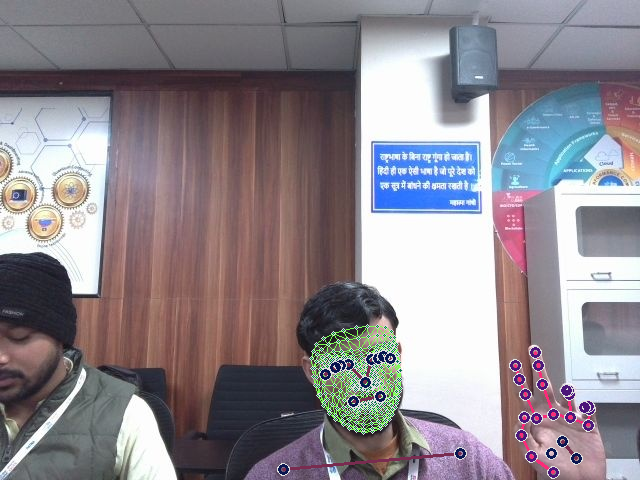

In [19]:
import cv2
from google.colab.patches import cv2_imshow # Added import
import mediapipe as mp # Added import

image_path = "/content/images/img_3.jpg"
image_to_process = cv2.imread(image_path)

if image_to_process is not None:
    # Create a holistic model instance here
    with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic_model:
        # Pass the NumPy array image and the holistic_model instance to mediapipe_detection
        processed_image, results = mediapipe_detection(image_to_process, holistic_model)
        # Pass the processed image to draw_landmarks
        draw_styled_landmarks(processed_image, results)
        # Display the image with landmarks
        cv2_imshow(processed_image)
else:
    print(f"Error: Could not load image from {image_path}")

In [20]:
#extracting all the values from pose, face, lh and rh into np array
len(results.left_hand_landmarks.landmark)

21

In [21]:
pose=[]
for res in results.pose_landmarks.landmark:
  test = np.array([res.x, res.y, res.z, res.visibility])
  pose.append(test)


In [23]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.z, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [27]:
print(lh)

[ 9.04204249e-01  1.00505793e+00  1.83896915e-07  8.64769816e-01
  9.85179305e-01 -1.64560433e-02  8.30125988e-01  9.50290501e-01
 -2.48029027e-02  8.15225363e-01  9.08312380e-01 -3.31716426e-02
  8.19646716e-01  8.69451880e-01 -3.99004146e-02  8.38609815e-01
  8.72230113e-01 -4.93877660e-03  8.21589112e-01  8.20841312e-01
 -1.66506320e-02  8.12000632e-01  7.90115178e-01 -2.66458504e-02
  8.05813015e-01  7.61635005e-01 -3.42918485e-02  8.64354074e-01
  8.62553358e-01 -7.77791254e-03  8.48229885e-01  8.01627576e-01
 -1.88286249e-02  8.40770066e-01  7.62402773e-01 -2.96902377e-02
  8.36792588e-01  7.33653843e-01 -3.73211242e-02  8.91504109e-01
  8.69174719e-01 -1.38430437e-02  8.90111983e-01  8.22808206e-01
 -3.14248055e-02  8.88994634e-01  8.13301206e-01 -4.15274836e-02
  8.85310590e-01  8.14580739e-01 -4.55489978e-02  9.19966698e-01
  8.86472464e-01 -2.12276410e-02  9.21762705e-01  8.52741241e-01
 -3.72499786e-02  9.18988228e-01  8.46185923e-01 -4.30181287e-02
  9.13553357e-01  8.49367

In [28]:
def extract_keypoints(results):
  pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
  face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
  lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
  rh = np.array([[res.z, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
  return np.concatenate([pose, face,lh,rh])

In [29]:
result_test = extract_keypoints(results)

In [30]:
result_test

array([ 0.57070816,  0.79615062, -0.58477312, ...,  0.        ,
        0.        ,  0.        ])

In [31]:
np.save('0', result_test)

In [32]:
np.load('0.npy')

array([ 0.57070816,  0.79615062, -0.58477312, ...,  0.        ,
        0.        ,  0.        ])

In [35]:
#setting up folder for collection
DATA_PATH = os.path.join('images')
#actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])
#Thirty videos worth of data
no_sequences =30
#videos are going to be 30 frame in length
sequence_length = 30
#folder start
start_folder = 30


In [39]:
for action in actions:
  # Get existing directories that are numbers
  existing_dirs = [d for d in os.listdir(os.path.join(DATA_PATH, action)) if d.isdigit()]
  if existing_dirs:
    dirmax = np.max(np.array(existing_dirs).astype(int))
  else:
    dirmax = 0 # Default to 0 if no existing numbered directories

  for sequence in range(1, no_sequences + 1):
    try:
      os.makedirs(os.path.join(DATA_PATH, action, str(dirmax + sequence)))
    except:
      pass

Collect keypints values for training and testing

In [50]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # NEW Apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Preprocess data and create labels and features

In [51]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [53]:
label_map = {label:num for num, label in enumerate(actions)}

In [54]:
label_map

{np.str_('hello'): 0, np.str_('thanks'): 1, np.str_('iloveyou'): 2}

In [56]:
sequences, labels = [], []
for action in actions:
  for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
    window = []
    for frame_num in range(sequence_length):
      try:
        res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
        window.append(res)
      except FileNotFoundError:
        print(f"Warning: {os.path.join(DATA_PATH, action, str(sequence), str(frame_num) + '.npy')} not found. Skipping this frame.")
        # You might choose to skip the entire sequence or append zeros if a frame is missing
        # For now, we'll just skip the frame, which might result in incomplete sequences.
        continue # Skip to the next frame_num
    # Only append the window if it's a complete sequence (or you handle incomplete sequences)
    if len(window) == sequence_length:
        sequences.append(window)
        labels.append(label_map[action])
    else:
        print(f"Warning: Sequence {action}/{sequence} is incomplete. Skipping.")